# Importación de librerías

In [1]:
import pathlib
from keras import models
from keras.models import Sequential, Model
from keras.layers import Conv2D,MaxPooling2D,Flatten,Dense,Dropout,Rescaling,experimental,Input,GlobalAveragePooling2D
from keras.layers.experimental import preprocessing
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import ResNet50,ResNet101,ResNet50V2,ResNet101V2
from keras.optimizers import Adam, SGD,RMSprop
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.applications.efficientnet import EfficientNetB0,EfficientNetB1,EfficientNetB2,EfficientNetB3,EfficientNetB4,EfficientNetB5,EfficientNetB6,EfficientNetB7
from keras.applications import EfficientNetV2B0,EfficientNetV2B1,EfficientNetV2B2,EfficientNetV2B3
from keras.metrics import CategoricalAccuracy, Precision, Recall, AUC, Metric
from keras.backend import epsilon
from keras.utils import register_keras_serializable

import numpy as np
from numpy.random import test
import matplotlib.pyplot as plt
import pickle
from tensorflow import keras,round
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize
import seaborn as sns



# Carga Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Jan 10 21:58:24 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P0              43W / 400W |      2MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

# Directorios y constantes

- Directorios donde están el conjunto de datos de entrenamiento, validación y test descargados de Kagle.
- Directorio de almacenamiento de resultado de entrenamiento
- Constantes

In [4]:
# Directorio de conjunto de datos de entrenamiento
data_dir = pathlib.Path('/content/gdrive/MyDrive/descargas_kaggle/butterfly-images40-species/train')
# Directorio de conjunto de datos de validación
valid_dir = pathlib.Path('/content/gdrive/MyDrive/descargas_kaggle/butterfly-images40-species/valid')
# Directorio de conjunto de datos de test
test_dir = pathlib.Path('/content/gdrive/MyDrive/descargas_kaggle/butterfly-images40-species/test')
# Directorio de almacenamiento de resultados
result_dir = pathlib.Path('/content/gdrive/MyDrive/TFM/RESULTS/final')

# Tamaño de la Imagen: Dimensiones (altura, anchura)
IMAGE_SIZE = (224, 224)
# Forma de Entrada del Modelo: Define las dimensiones de entrada que espera el modelo.
INPUT_SHAPE = (224, 224, 3)


# Funciones de creación de modelos
Funciones  para la construcción de modelos basados en las arquitecturas de redes neuronales ResNet, EfficientNet y modelo secuencial para la clasificación de 100 clases

In [5]:
def create_sequential_CNN(show_summary):
    """
    Crea un modelo de clasificación secuencial utilizando una arquitectura CNN personalizada.

    Args:
    show_summary (bool): Si es True, muestra el resumen del modelo.

    Devuelve:
    Sequential: El modelo de Keras basado en una arquitectura CNN.
    """
    classifier = Sequential()

    # Primera capa Convolución y Max Pooling
    classifier.add(Conv2D(filters=32, kernel_size=(3, 3), input_shape=INPUT_SHAPE, activation="relu"))
    classifier.add(MaxPooling2D(pool_size=(2, 2)))

    # Segunda capa Convolución y Max Pooling
    classifier.add(Conv2D(filters=64, kernel_size=(3, 3), activation="relu"))
    classifier.add(MaxPooling2D(pool_size=(2, 2)))

    # Tercera capa Convolución y Max Pooling
    classifier.add(Conv2D(filters=128, kernel_size=(3, 3), activation="relu"))
    classifier.add(MaxPooling2D(pool_size=(2, 2)))

    # Cuarta capa Convolución y Max Pooling
    classifier.add(Conv2D(filters=256, kernel_size=(3, 3), activation="relu"))
    classifier.add(MaxPooling2D(pool_size=(2, 2)))

    # Paso 3 - Flattening
    classifier.add(Flatten())

    # Paso 4 - Red neuronal
    classifier.add(Dense(units=512, activation="relu"))
    classifier.add(Dropout(0.5))
    classifier.add(Dense(units=100, activation="softmax"))

    # Compilación del modelo
    classifier.build(input_shape=(None, 224, 224, 3))

    # Mostrar resumen del modelo
    if show_summary:
        classifier.summary()

    return classifier


def create_model_ResNet(model_name,show_summary):
    """
    Crea un modelo de clasificación utilizando una de las variantes de ResNet.

    Args:
    model_name (str): Nombre del modelo base de ResNet a utilizar. Puede ser 'resnet101',
                      'resnet101V2', 'resnet50V2' o 'resnet50'.
    show_summary (bool): Si es True, muestra el resumen del modelo.

    Devuelve:
    Model: El modelo de Keras basado en la arquitectura ResNet especificada.

    Esta función crea un modelo de clasificación basado en la arquitectura ResNet.
    Utiliza pesos pre-entrenados de ImageNet y añade capas densas al final para
    realizar la clasificación en 100 clases. Incluye una capa de Dropout para
    reducir el overfitting.
    """
    input_tensor = Input(shape=INPUT_SHAPE)
    # generación del modelo base ResNet
    if model_name == 'resnet101':
        base_model = ResNet101(weights='imagenet', include_top=False, input_shape=INPUT_SHAPE, pooling='avg')
    elif model_name == 'resnet101V2':
        base_model = ResNet101V2(weights='imagenet', include_top=False, input_shape=INPUT_SHAPE, pooling='avg')
    elif model_name == 'resnet50V2':
        base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=INPUT_SHAPE, pooling='avg')
    elif model_name == 'resnet50':
        base_model = ResNet50(weights='imagenet', include_top=False, input_shape=INPUT_SHAPE, pooling='avg')
    else:
        raise ValueError(f"Modelo '{model_name}' no reconocido")
    x = base_model.output
    x = Dense(2048, activation='relu')(x)
    x = Dense(1024, activation='relu')(x)
    # para prevenir overfitting
    x = Dropout(0.5)(x)
    # Capa softmax para obtener la clasificación de las 100 especies
    output = Dense(100, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=output)
    model.build(input_shape=(None, 224, 224, 3))
    # Comprobando si se muestra summario del modelo
    if show_summary:
      model.summary()
    return model

def create_model_EfficientNet(model_name, show_summary):
    """
    Crea un modelo de clasificación utilizando una de las variantes de EfficientNet.

    Args:
    model_name (str): Nombre del modelo base de EfficientNet a utilizar. Las opciones son
                      'efficientnetB0', 'efficientnetB1', 'efficientnetB2', 'efficientnetB3',
                      y 'efficientnetB4'.
    show_summary (bool): Si es True, muestra el resumen del modelo.

    Devuelve:
    Model: Un modelo de Keras basado en la arquitectura EfficientNet especificada.

    Esta función construye un modelo de clasificación basado en la arquitectura EfficientNet.
    Se inicializa con pesos pre-entrenados de ImageNet y se personaliza para la clasificación
    en 100 clases. Incluye una capa de Dropout para reducir el overfitting y dos capas densas
    adicionales para procesamiento y clasificación.
    """
    input_tensor = Input(shape=INPUT_SHAPE)
    # generación del modelo base EfficientNet
    if model_name == 'efficientnetB0':
        base_model = EfficientNetB0(input_shape=INPUT_SHAPE, include_top=False, weights='imagenet', pooling='avg')
    elif model_name == 'efficientnetB1':
        base_model = EfficientNetB1(input_shape=INPUT_SHAPE, include_top=False, weights='imagenet', pooling='avg')
    elif model_name == 'efficientnetB2':
        base_model = EfficientNetB2(input_shape=INPUT_SHAPE, include_top=False, weights='imagenet', pooling='avg')
    elif model_name == 'efficientnet3':
        base_model = EfficientNetB3(input_shape=INPUT_SHAPE, include_top=False, weights='imagenet', pooling='avg')
    elif model_name == 'efficientnetB4':
        base_model = EfficientNetB4(input_shape=INPUT_SHAPE, include_top=False, weights='imagenet', pooling='avg')
    elif model_name == 'efficientnetB5':
        base_model = EfficientNetB5(input_shape=INPUT_SHAPE, include_top=False, weights='imagenet', pooling='avg')
    elif model_name == 'efficientnetB6':
        base_model = EfficientNetB6(input_shape=INPUT_SHAPE, include_top=False, weights='imagenet', pooling='avg')
    elif model_name == 'efficientnetB7':
        base_model = EfficientNetB7(input_shape=INPUT_SHAPE, include_top=False, weights='imagenet', pooling='avg')
    elif model_name == 'efficientnetV2B0':
        base_model = EfficientNetV2B0(input_shape=INPUT_SHAPE, include_top=False, weights='imagenet', pooling='avg')
    elif model_name == 'efficientnetV2B1':
        base_model = EfficientNetV2B1(input_shape=INPUT_SHAPE, include_top=False, weights='imagenet', pooling='avg')
    elif model_name == 'efficientnetV2B2':
        base_model = EfficientNetV2B2(input_shape=INPUT_SHAPE, include_top=False, weights='imagenet', pooling='avg')
    elif model_name == 'efficientnetV2B3':
        base_model = EfficientNetV2B3(input_shape=INPUT_SHAPE, include_top=False, weights='imagenet', pooling='avg')
    else:
        raise ValueError(f"Modelo '{model_name}' no reconocido")
    x = base_model.output
    x = Dense(4096, activation='relu')(x)
    x = Dense(2048, activation='relu')(x)
    # para prevenir overfitting
    x = Dropout(0.5)(x)
    # Capa softmax para obtener la clasificación de las 100 especies
    output = Dense(100, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=output)
    model.build(input_shape=(None, 224, 224, 3))
    # Comprobando si se muestra summario del modelo
    if show_summary:
      model.summary()
    return model


# Carga y preprocesado de imágenes del conjunto de datos

In [6]:
# Generador para conjunto de datos de entrenamiento
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)
# Generador para conjunto de datos de validación
validation_datagen = ImageDataGenerator(rescale=1./255)
#Generador para conjunto de datos de test
test_datagen = ImageDataGenerator(rescale=1./255)
# Dataset de entrenamiento
training_dataset = train_datagen.flow_from_directory(
        data_dir,
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical')

# Etiquetas correctas de tus clases
class_labels = training_dataset.classes

# Calculo los pesos de las clases en dataset de entrenamiento para balanceo
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(class_labels),
    y=class_labels)

class_weights_dict = {i : class_weights[i] for i in range(len(class_weights))}
# Dataset de validación
validation_dataset = validation_datagen.flow_from_directory(
        valid_dir,
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical')
# Dataset de test
testing_dataset = test_datagen.flow_from_directory(
        test_dir,
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical',
        shuffle=False)
class_names = list(training_dataset.class_indices.keys())

Found 12594 images belonging to 100 classes.
Found 500 images belonging to 100 classes.
Found 500 images belonging to 100 classes.


# Imágenes del conjunto de datos de entrenamiento

La clase con menos muestras es 'SIXSPOT BURNET MOTH' con 100 muestras.
La clase con más muestras es 'MOURNING CLOAK' con 187 muestras.


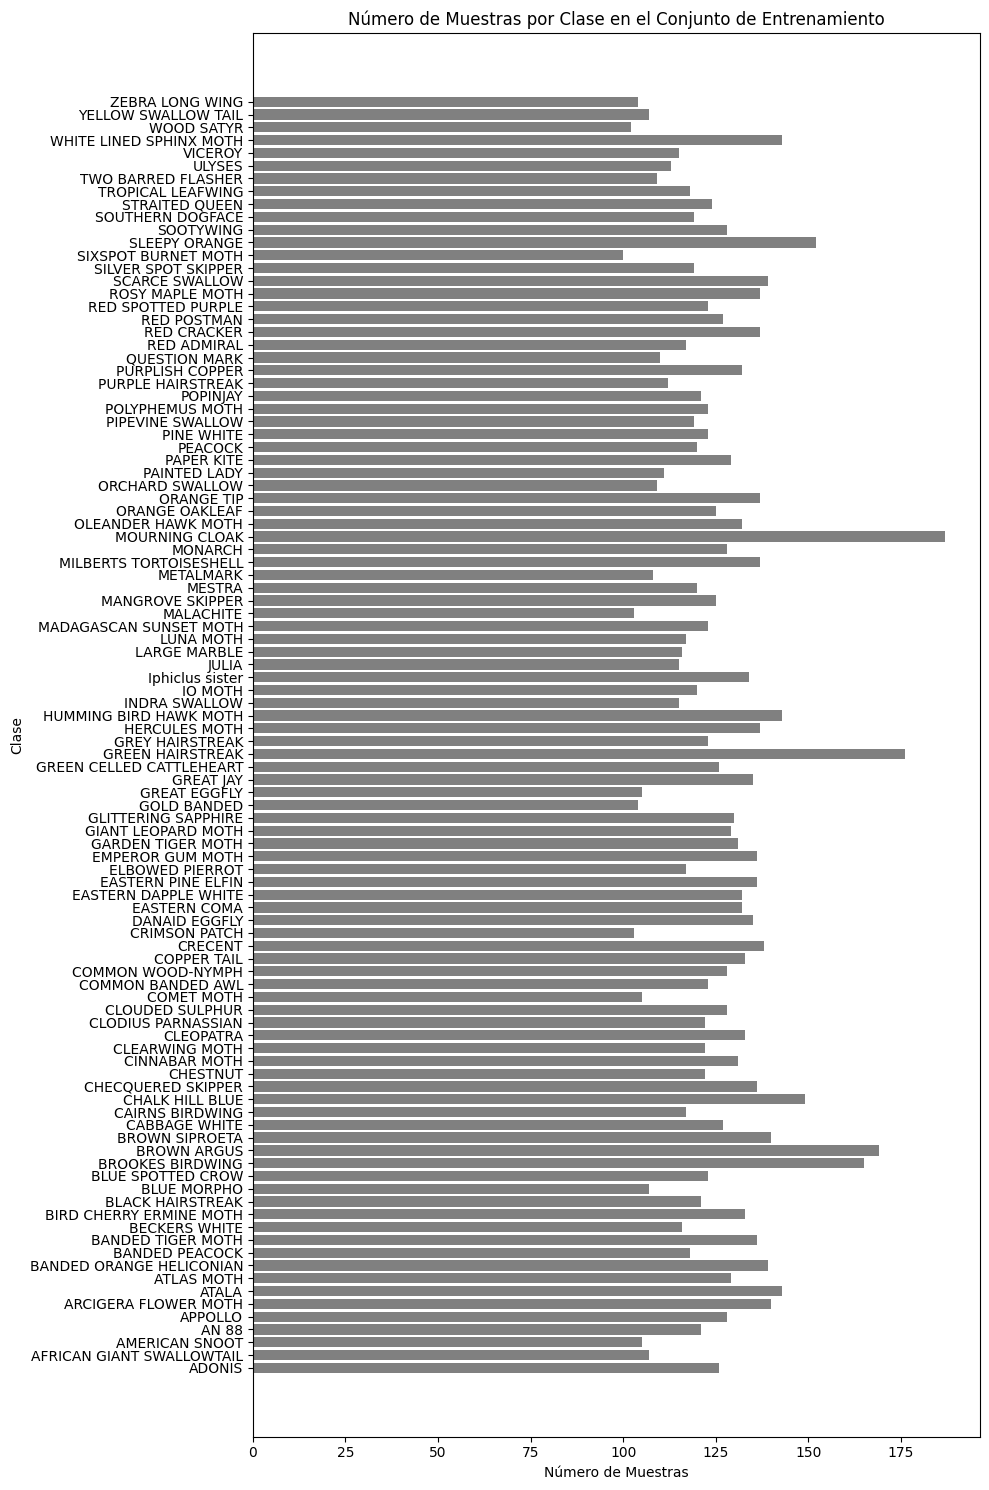

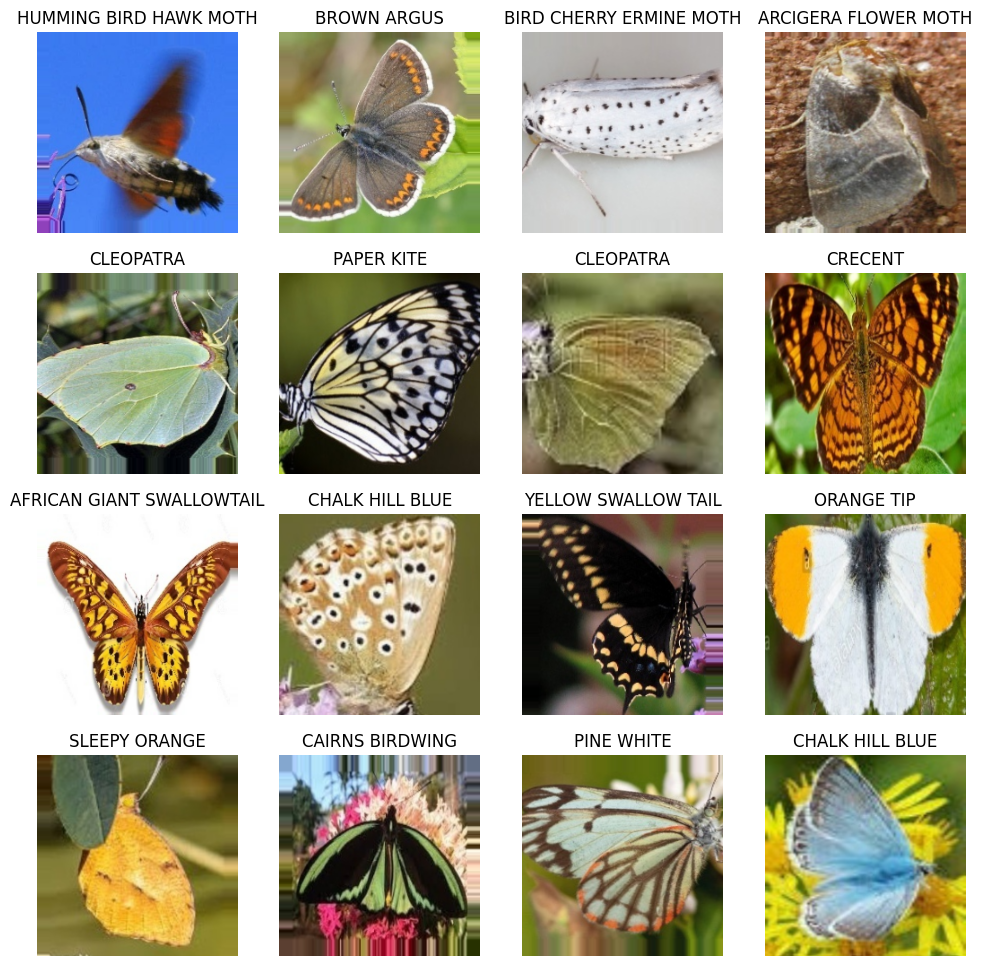

In [7]:
def analyze_and_visualize_classes(training_dataset, class_names):
    """
    Analiza y visualiza la distribución de clases en el conjunto de entrenamiento.

    :param training_dataset: Conjunto de datos de entrenamiento.
    :param class_names: Lista de nombres de clases.
    """
    # Número de muestras por clase en el conjunto de entrenamiento
    train_counts = training_dataset.classes
    unique, counts = np.unique(train_counts, return_counts=True)
    train_class_counts = dict(zip(class_names, counts))

    # Identifica la clase con menor y mayor número de muestras
    min_class = min(train_class_counts, key=train_class_counts.get)
    max_class = max(train_class_counts, key=train_class_counts.get)
    min_value = train_class_counts[min_class]
    max_value = train_class_counts[max_class]

    print(f"La clase con menos muestras es '{min_class}' con {min_value} muestras.")
    print(f"La clase con más muestras es '{max_class}' con {max_value} muestras.")

    # Creación de un gráfico de barras horizontal
    plt.figure(figsize=(10, 15))
    plt.barh(list(train_class_counts.keys()), list(train_class_counts.values()), color='grey')
    plt.ylabel('Clase')
    plt.xlabel('Número de Muestras')
    plt.title('Número de Muestras por Clase en el Conjunto de Entrenamiento')
    plt.tight_layout()
    plt.show()


def display_batch_images(dataset, class_names):
    """
    Muestra las primeras 16 imágenes de un lote del conjunto de datos junto con sus etiquetas.

    Parámetros:
    dataset: Conjunto de datos del que se extraerán las imágenes.
    class_names: Lista de nombres de clases para etiquetar las imágenes.
    """
    # Obtener un lote de imágenes y etiquetas
    images, labels = next(dataset)

    # Mostrar las primeras 16 imágenes del lote
    plt.figure(figsize=(12, 12))
    for i in range(16):
        plt.subplot(4, 4, i + 1)
        plt.imshow(images[i])

        # Encuentra el índice de la clase (índice del valor máximo en el vector one-hot)
        class_index = np.argmax(labels[i])

        plt.title(class_names[class_index])
        plt.axis("off")

    plt.show()

# Llamada a las funciones
analyze_and_visualize_classes(training_dataset=training_dataset, class_names=class_names)
display_batch_images(dataset=training_dataset, class_names=class_names)



# Funciones carga y deescarga de fichero de resultado de entrenamiento

In [8]:
def save_result_model(model, history, result_dir, file):
    """
    Guarda el modelo entrenado y su historial de entrenamiento en el directorio especificado.

    Parámetros:
    model: El modelo de Keras que se desea guardar.
    history: El historial de entrenamiento del modelo.
    result_dir: Directorio Path donde se guardarán el modelo y el historial.
    file: Nombre base del archivo para guardar el modelo y el historial.
    """
    # Guarda el modelo en formato .hd5
    model_path = result_dir / (file + '.hd5')
    model.save(model_path)

    # Guarda el historial de entrenamiento en formato .pkl
    history_path = result_dir / (file + '.pkl')
    with history_path.open('wb') as historyFile:
        pickle.dump(history, historyFile)

def load_result_model(result_dir, file):
    """
    Carga un modelo y su historial de entrenamiento desde el directorio y nombre de archivo especificados.

    Parámetros:
    result_dir: Directorio Path de donde se cargarán el modelo y el historial.
    file: Nombre base del archivo para cargar el modelo y el historial.

    Devuelve:
    model: El modelo de Keras cargado.
    history: El historial de entrenamiento del modelo.
    """
    # Cargar el modelo desde el archivo .hd5
    model_file_path = result_dir / (file + '.hd5')
    model = models.load_model(model_file_path)

    # Cargar el historial de entrenamiento desde el archivo .pkl
    history_file_path = result_dir / (file + '.pkl')
    with history_file_path.open('rb') as historyStream:
        history = pickle.load(historyStream)

    return model, history

# Función para pintar gráficas del entrenamiento

In [18]:
def plot_training_history(history_saved):
    """
    Genera gráficos de la historia de entrenamiento de un modelo.

    Args:
    history_saved: Objeto history devuelto por el método fit() de un modelo de Keras.

    Esta función genera gráficos para visualizar la precisión categórica, la pérdida,
    la precisión, el recall, el AUC, el PRC y F1-SCORE del entrenamiento y la validación a lo
    largo de las épocas. Ayuda a entender cómo ha evolucionado el rendimiento del
    modelo durante el entrenamiento.
    """
    # Número de épocas del entrenamiento
    num_epochs = len(history_saved.history['categorical_accuracy'])

    # Ajuste de la altura para 7 gráficas
    plt.figure(figsize=(6, 54))

    # Gráfico de Precisión de Entrenamiento y Validación
    plt.subplot(7, 1, 1)
    plt.plot(range(num_epochs), history_saved.history['categorical_accuracy'], label='Categorical accuracy de Entrenamiento')
    plt.plot(range(num_epochs), history_saved.history['val_categorical_accuracy'], label='Categorical accuracy de Validación')
    plt.legend(loc='lower right')
    plt.title('Categorical accuracy de Entrenamiento y Validación')

    # Gráfico de Pérdida de Entrenamiento y Validación
    plt.subplot(7, 1, 2)
    plt.plot(range(num_epochs), history_saved.history['loss'], label='Pérdida de Entrenamiento')
    plt.plot(range(num_epochs), history_saved.history['val_loss'], label='Pérdida de Validación')
    plt.legend(loc='upper right')
    plt.title('Pérdida de Entrenamiento y Validación')

    # Gráfico de Precisión
    plt.subplot(7, 1, 3)
    plt.plot(range(num_epochs), history_saved.history['precision'], label='Precisión de Entrenamiento')
    plt.plot(range(num_epochs), history_saved.history['val_precision'], label='Precisión de Validación')
    plt.legend(loc='lower right')
    plt.title('Precisión de Entrenamiento y Validación')

    # Gráfico de Recall
    plt.subplot(7, 1, 4)
    plt.plot(range(num_epochs), history_saved.history['recall'], label='Recall de Entrenamiento')
    plt.plot(range(num_epochs), history_saved.history['val_recall'], label='Recall de Validación')
    plt.legend(loc='lower right')
    plt.title('Recall de Entrenamiento y Validación')

    # Gráfico de AUC
    plt.subplot(7, 1, 5)
    plt.plot(range(num_epochs), history_saved.history['auc'], label='AUC de Entrenamiento')
    plt.plot(range(num_epochs), history_saved.history['val_auc'], label='AUC de Validación')
    plt.legend(loc='lower right')
    plt.title('AUC de Entrenamiento y Validación')

    # Gráfico de PRC
    plt.subplot(7, 1, 6)
    plt.plot(range(num_epochs), history_saved.history['prc'], label='PRC de Entrenamiento')
    plt.plot(range(num_epochs), history_saved.history['val_prc'], label='PRC de Validación')
    plt.legend(loc='lower right')
    plt.title('PRC de Entrenamiento y Validación')

    # Gráfico de F1 Score
    plt.subplot(7, 1, 7)
    plt.plot(range(num_epochs), history_saved.history['f1_score'], label='F1 Score de Entrenamiento')
    plt.plot(range(num_epochs), history_saved.history['val_f1_score'], label='F1 Score de Validación')
    plt.legend(loc='lower right')
    plt.title('F1 Score de Entrenamiento y Validación')

    plt.show()


# Funciones gráficas predicción

In [10]:
def plot_multiclass_roc_auc(true_labels, predictions, class_names):
    """
    Genera y muestra la curva ROC y calcula el AUC para un problema de clasificación multiclase.

    :param true_labels: Array de etiquetas verdaderas.
    :param predictions: Array de probabilidades predichas por el modelo, con una columna por clase.
    :param class_names: Lista de nombres de clases en el mismo orden que las columnas de 'predictions'.
    """
    # Binariza las etiquetas en formato one-hot
    y_bin = label_binarize(true_labels, classes=np.arange(len(class_names)))

    # Calcula la curva ROC y AUC para cada clase
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(len(class_names)):
        fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], predictions[:, i])
        roc_auc[i] = roc_auc_score(y_bin[:, i], predictions[:, i])

    # Calcula la curva ROC y AUC promedio
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(class_names))]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(len(class_names)):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= len(class_names)

    roc_auc_avg = np.mean(list(roc_auc.values()))

    # MuestrA la curva ROC para todas las clases
    plt.figure()
    plt.plot(all_fpr, mean_tpr, color='blue', label='Mean ROC (AUC = %0.2f)' % roc_auc_avg)
    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Multiclass ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

def plot_confusion_matrix(true_labels, predicted_labels, class_names):
    """
    Genera y muestra la matriz de confusión.

    :param true_labels: Array de etiquetas verdaderas.
    :param predicted_labels: Array de etiquetas predichas por el modelo.
    :param class_names: Lista de nombres de clases.
    """
    cm = confusion_matrix(true_labels, predicted_labels)

    plt.figure(figsize=(20, 15))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Clases Predichas')
    plt.ylabel('Clases Verdaderas')
    plt.title('Matriz de Confusión')
    plt.show()

def calculate_accuracy(true_labels, predicted_labels):
    """
    Calcula y muestra la precisión del modelo.

    :param true_labels: Array de etiquetas verdaderas del conjunto de prueba.
    :param predicted_labels: Array de etiquetas predichas por el modelo.
    :return: La precisión del modelo.
    """
    accuracy = accuracy_score(true_labels, predicted_labels)
    print("Precisión:", accuracy)
    return accuracy


# Entrenamiento

Métricas para el entrenamiento

In [19]:

@register_keras_serializable()
class F1Score(Metric):
    def __init__(self, name='f1_score', **kwargs):
        """
        Inicializa la métrica F1Score.
        Args:
        name (str): Nombre de la métrica.
        **kwargs: Argumentos adicionales.
        """
        super(F1Score, self).__init__(name=name, **kwargs)
        # Inicializa las métricas de precisión y recall
        self.precision = Precision()
        self.recall = Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        """
        Actualiza el estado de la métrica basado en las etiquetas verdaderas y las predicciones.

        Args:
        y_true: Etiquetas verdaderas.
        y_pred: Predicciones del modelo.
        sample_weight: Ponderaciones de las muestras (opcional).
        """
        # Redondea las predicciones para clasificación binaria
        y_pred = round(y_pred)
        # Actualiza la precisión y el recall con los nuevos valores
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        """
        Calcula y devuelve el valor actual de F1 Score.
        Returns:
        Un tensor con el valor de F1 Score.
        """
        precision = self.precision.result()
        recall = self.recall.result()
        # Calcula el F1 Score usando la fórmula y evita división por cero
        return 2 * ((precision * recall) / (precision + recall + epsilon()))

    def reset_states(self):
        """
        Reinicia los estados de las métricas de precisión y recall.
        """
        # Reinicia los estados de las métricas internas
        self.precision.reset_states()
        self.recall.reset_states()

    def get_config(self):
        """
        Devuelve la configuración de la métrica.
        Returns:
        Un diccionario de configuración.
        """
        base_config = super(F1Score, self).get_config()
        return {**base_config}

# Métricas para el entrenamiento
METRICS = [
      CategoricalAccuracy(name='categorical_accuracy'),
      Precision(name='precision'),
      Recall(name='recall'),
      AUC(name='auc'),
      AUC(name='prc', curve='PR'),
      F1Score()
]



# MODELO SECUENCIAL

In [21]:
# Nombre del modelo y archivo
name_file="sequential_CNN_ADAM"
num_epochs=30

# Creación de modelo mostrando summary
model_seq = create_sequential_CNN(show_summary=True)

# Configuración del optimizador
#optimizer= SGD()
optimizer= Adam(learning_rate=0.0005)
# Compilación el modelo con el optimizador, función de pérdida y métricas
model_seq.compile(optimizer, loss='categorical_crossentropy', metrics=METRICS)

# Callback para reducir la tasa de aprendizaje si no hay mejora en 'val_loss'
rlr_callback = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, mode='min', verbose=1)
# Callback para detener el entrenamiento si no hay mejora en 'val_loss'
early_callback = EarlyStopping(monitor='val_loss', patience=5, mode='min', verbose=1)

# Entrenamiento del modelo
history_seq = model_seq.fit(training_dataset, epochs=num_epochs,
         steps_per_epoch=394,
         validation_data=validation_dataset,
         validation_steps=16,
         callbacks=[rlr_callback, early_callback],
                    class_weight=class_weights_dict)

# Almacena el modelo y su historial
save_result_model(model_seq, history_seq, result_dir, name_file)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 111, 111, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 54, 54, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_14 (Conv2D)          (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_14 (MaxPooli  (None, 26, 26, 128)      

# Métricas
Carga del fichero de resultado y obtención de métricas

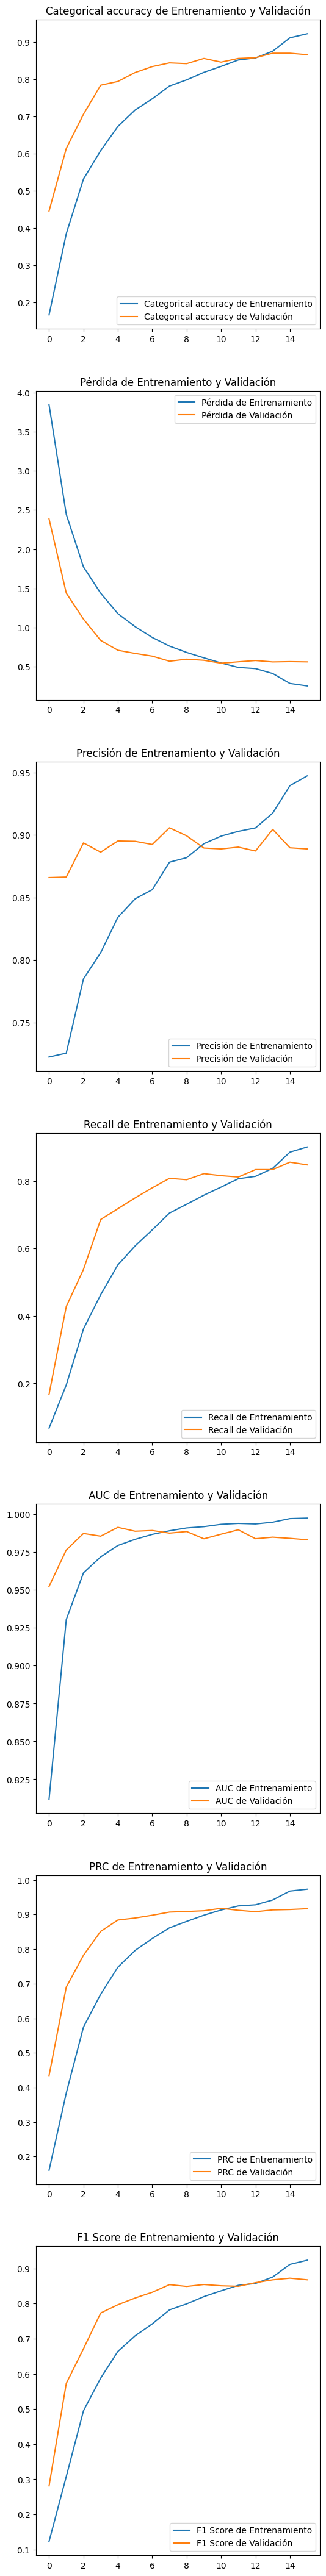

In [22]:
# se carga el modelo y la historia
# [model_seq_saved, history_seq_saved] = load_result_model(result_dir,name_file)
history_seq_saved=history_seq
model_seq_saved=model_seq
plot_training_history(history_seq_saved)


# Evaluación

In [23]:
# Reseteo del generador antes de evaluar el modelo
testing_dataset.reset()
# Evaluación del modelo en el conjunto de prueba
results = model_seq_saved.evaluate(testing_dataset)

# Se obtienen los nombres de las métricas
metrics_names = model_seq_saved.metrics_names

# Se muestran todas las métricas
print("Métricas en el conjunto de prueba:")
for metric, value in zip(metrics_names, results):
    print(f"{metric}: {value}")

 2/16 [==>...........................] - ETA: 1s - loss: 0.1281 - categorical_accuracy: 0.9219 - precision: 0.9516 - recall: 0.9219 - auc: 0.9999 - prc: 0.9929 - f1_score: 0.9365

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:2723: UserWarning: Metric F1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()


16/16 [==============================] - 1s 74ms/step - loss: 0.3558 - categorical_accuracy: 0.9080 - precision: 0.9278 - recall: 0.9000 - auc: 0.9886 - prc: 0.9538 - f1_score: 0.9137
Métricas en el conjunto de prueba:
loss: 0.35582235455513
categorical_accuracy: 0.9079999923706055
precision: 0.9278350472450256
recall: 0.8999999761581421
auc: 0.9886062741279602
prc: 0.9537612199783325
f1_score: 0.9137054681777954


# Predicción

16/16 [==============================] - 1s 74ms/step
Clases predichas: [ 0  0  0  0  0  1  1  1  1  1  2  2 31  2  2  3  3  3  3  3  4  4  4  4
  4 75  5  5  5  5  6  6  6  6  6  7  7  7  7  7  8  8 80  8  8  9  9  9
  9  9 10 10 10 10 10 11 11 11 73 11 73 12 12 12 12 13 13 13 13 13 14 14
 38 14 14 15 15 15 15 15 16 47 16 16 16 17 49 17 17 17 18 18 18 18 18 19
 19 19 19 19 20 20 20 20 20 21 21 21 32 21 22 22 22 22 22 23 23 23 23 23
 24 24 24 24 24  5 25 25 25 25 26 26 26 26 26 27 27 27 27 27 28 28 28 28
 28 29 29 29 29 29 30 30 30 30 30 31 31 31 31 31 32 32 78 33 32 70 33 33
 22 33 34  6 34 34 34 35 35 35 35 35 79 36 36 36 79 37 73 56 56 37 38 38
 38 38 38 54 39 39 39 39 40 40 40 40 40 41 54 41 41 41 42 42 42 42 42 43
 43 43 43 43 44 44 44 44 44 35 62 45 45 35 46 46 46 46 46 47 47 47 47 47
 48 48 48 48 48 49 49 49 49  0 50 50 50 50  7 51 51 51 51 51 52 52 52 52
 52 53 53 53 53 53 54 54 54 54 54 55 55 55 55 55 56 56 56 56 68 57 57 57
 57 57 58 58 58 58 58 37 59 59 59 59 60 60 60 60 60 

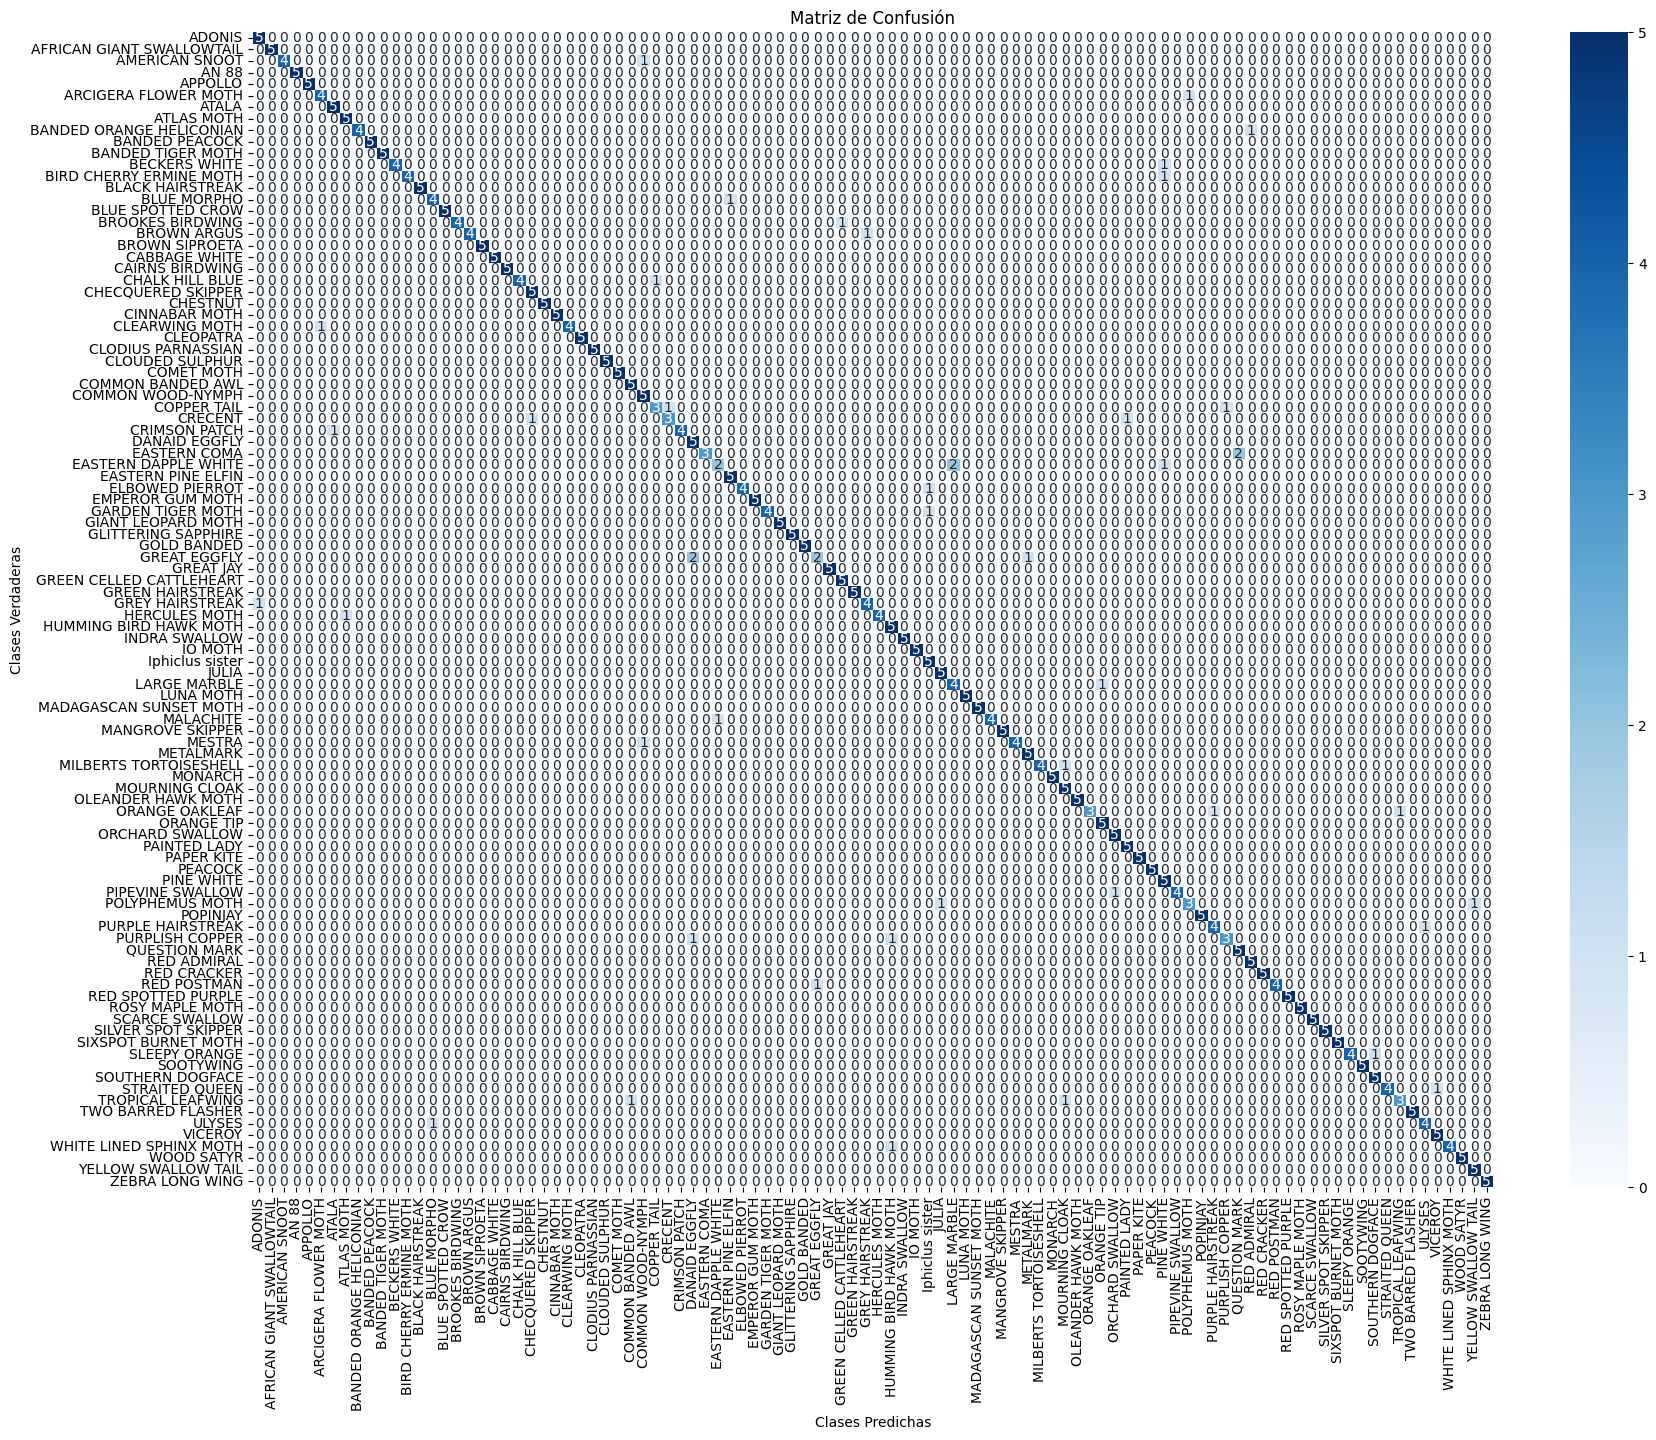

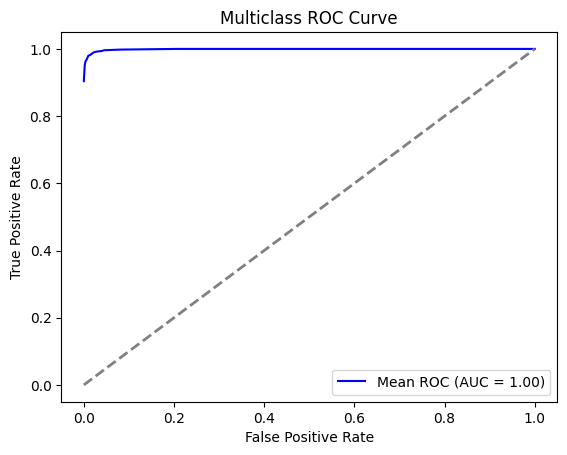

                           precision    recall  f1-score   support

                   ADONIS       0.83      1.00      0.91         5
AFRICAN GIANT SWALLOWTAIL       1.00      1.00      1.00         5
           AMERICAN SNOOT       1.00      0.80      0.89         5
                    AN 88       1.00      1.00      1.00         5
                  APPOLLO       1.00      1.00      1.00         5
     ARCIGERA FLOWER MOTH       0.80      0.80      0.80         5
                    ATALA       0.83      1.00      0.91         5
               ATLAS MOTH       0.83      1.00      0.91         5
 BANDED ORANGE HELICONIAN       1.00      0.80      0.89         5
           BANDED PEACOCK       1.00      1.00      1.00         5
        BANDED TIGER MOTH       1.00      1.00      1.00         5
            BECKERS WHITE       1.00      0.80      0.89         5
  BIRD CHERRY ERMINE MOTH       1.00      0.80      0.89         5
         BLACK HAIRSTREAK       1.00      1.00      1.00     

In [24]:
# Reseteo del generador antes de predecir el modelo
testing_dataset.reset()
# Predecir las clases para el conjunto de prueba
predictions_seq = model_seq_saved.predict(testing_dataset)

# Convertir las probabilidades predichas en etiquetas de clase
predicted_classes = np.argmax(predictions_seq, axis=1)

# Se muestran las clases predichas
print("Clases predichas:", predicted_classes)

true_labels = testing_dataset.classes
# Se obtiene accuracy
accuracy = calculate_accuracy(true_labels, predicted_classes)

# Matriz de confusión
plot_confusion_matrix(true_labels, predicted_classes, class_names)

# Curva roc auc
plot_multiclass_roc_auc(true_labels, predictions_seq, class_names)

# Calcula el reporte de clasificación y se imprime
report = classification_report(true_labels, predicted_classes, target_names=class_names)
print(report)


# RESNET

In [25]:
# Nombre del modelo y archivo
model_name="resnet101V2"
name_file="resnet101V2_SGD"
num_epochs=30

# Creación de modelo ResNet101 mostrando summary
model = create_model_ResNet(model_name=model_name, show_summary=True)

# Configuración del optimizador
optimizer= SGD()
#optimizer= Adam()
# Compilación el modelo con el optimizador, función de pérdida y métricas
model.compile(optimizer, loss='categorical_crossentropy', metrics=METRICS)

# Callback para reducir la tasa de aprendizaje si no hay mejora en 'val_loss'
rlr_callback = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, mode='min', verbose=1)
# Callback para detener el entrenamiento si no hay mejora en 'val_loss'
early_callback = EarlyStopping(monitor='val_loss', patience=5, mode='min', verbose=1)

# Entrenamiento del modelo
history = model.fit(training_dataset, epochs=num_epochs,
         steps_per_epoch=394,
         validation_data=validation_dataset,
         validation_steps=16,
         callbacks=[rlr_callback, early_callback],
                    class_weight=class_weights_dict)

# Almacena el modelo y su historial
save_result_model(model, history, result_dir, name_file)


171317808/171317808 [==============================] - 8s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 114, 114, 64)         0         ['conv1_conv[0][0]']          
                           

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:2723: UserWarning: Metric F1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()


394/394 [==============================] - 175s 361ms/step - loss: 2.3264 - categorical_accuracy: 0.5170 - precision: 0.8986 - recall: 0.3223 - auc: 0.9328 - prc: 0.5523 - f1_score: 0.4744 - val_loss: 0.4182 - val_categorical_accuracy: 0.8880 - val_precision: 0.9208 - val_recall: 0.8600 - val_auc: 0.9933 - val_prc: 0.9439 - val_f1_score: 0.8893 - lr: 0.0100
Epoch 2/30
394/394 [==============================] - 144s 365ms/step - loss: 0.5533 - categorical_accuracy: 0.8556 - precision: 0.9200 - recall: 0.7905 - auc: 0.9921 - prc: 0.9225 - f1_score: 0.8504 - val_loss: 0.2751 - val_categorical_accuracy: 0.9280 - val_precision: 0.9443 - val_recall: 0.9160 - val_auc: 0.9957 - val_prc: 0.9676 - val_f1_score: 0.9299 - lr: 0.0100
Epoch 3/30
394/394 [==============================] - 145s 368ms/step - loss: 0.3219 - categorical_accuracy: 0.9134 - precision: 0.9456 - recall: 0.8838 - auc: 0.9963 - prc: 0.9650 - f1_score: 0.9137 - val_loss: 0.2409 - val_categorical_accuracy: 0.9540 - val_precision

# Métricas
Carga del fichero de resultado y obtención de métricas

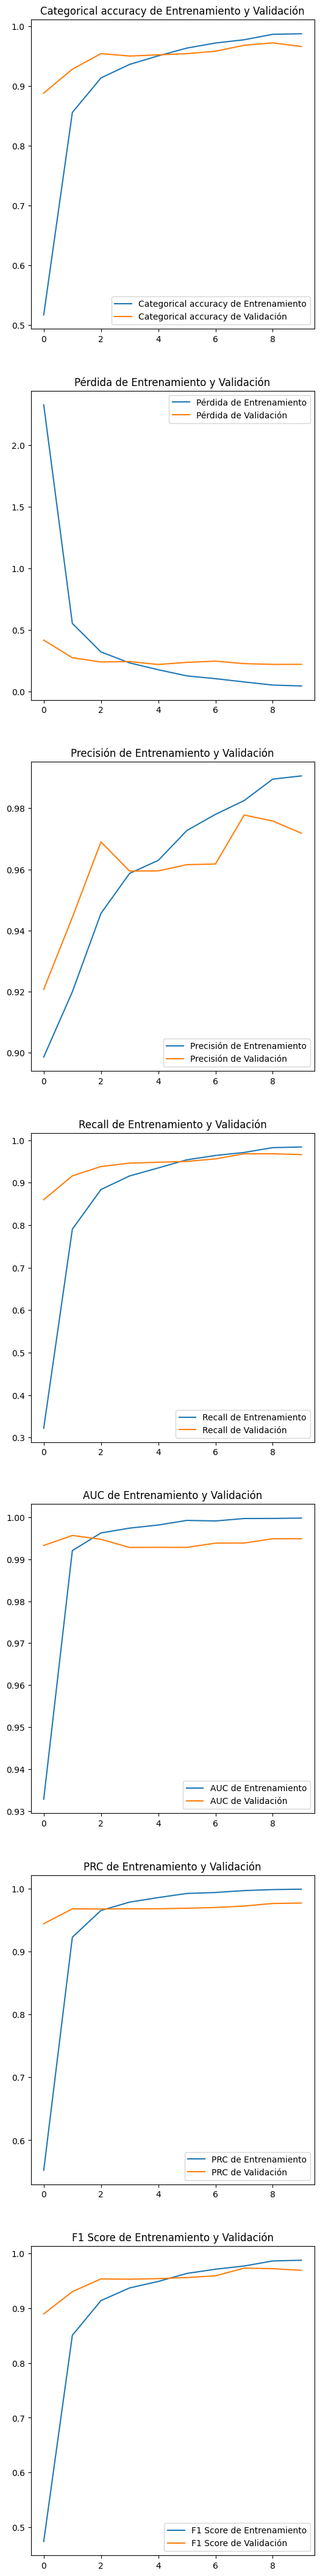

In [26]:
# se carga el modelo y la historia
#[model_saved, history_saved] = load_result_model(result_dir,name_file)
model_saved=model
history_saved=history
plot_training_history(history_saved)

# Evaluación

In [27]:
# Reseteo del generador antes de evaluar el modelo
testing_dataset.reset()
# Evaluar el modelo en el conjunto de prueba
results = model_saved.evaluate(testing_dataset)

# Se obtienen los nombres de las métricas
metrics_names = model_saved.metrics_names

# Imprimir todas las métricas
print("Métricas en el conjunto de prueba:")
for metric, value in zip(metrics_names, results):
    print(f"{metric}: {value}")

 1/16 [>.............................] - ETA: 2s - loss: 0.0683 - categorical_accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 1.0000 - prc: 0.9971 - f1_score: 0.9687

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:2723: UserWarning: Metric F1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()


16/16 [==============================] - 1s 77ms/step - loss: 0.0934 - categorical_accuracy: 0.9740 - precision: 0.9799 - recall: 0.9740 - auc: 0.9980 - prc: 0.9898 - f1_score: 0.9769
Métricas en el conjunto de prueba:
loss: 0.09343817830085754
categorical_accuracy: 0.9739999771118164
precision: 0.9798792600631714
recall: 0.9739999771118164
auc: 0.9979512691497803
prc: 0.9898124933242798
f1_score: 0.9769307374954224


# Predicción

16/16 [==============================] - 3s 74ms/step
Clases predichas: [ 0  0  0  0 21  1  1  1  1  1  2  2  2  2  2  3  3  3  3  3  4  4  4  4
  4  5  5  5  5  5  6  6  6  6  6  7  7  7  7  7  8  8  8  8  8  9  9  9
  9  9 10 10 10 10 10 11 11 11 11 11 12 12 12 12 12 13 13 13 13 13 14 14
 14 14 14 15 15 15 15 15 16 16 16 16 16  0 17 17 17 17 18 18 18 18 18 19
 19 19 19 19 20 20 20 20 20 21 21  0  0 21 22 22 22 22 22 23 23 23 23 23
 24 24 24 24 24 25 51 25 25 25 26 26 26 26 26 27 27 27 27 27 90 28 28 28
 28 29 29 29 29 29 30 30 30 30 30 31 31 31 31 31 32 32 32 78 32 70 33 33
 33 33 34 34 34 34 34 35 35 35 35 35 36 36 36 36 36 37 37 37 37 37 38 38
 38 38 38 39 39 39 39 39 40 40 40 40 40 41 41 41 41 41 42 42 42 42 42 43
 43 43 43 43 44 44 44 44 44 45 45 45 45 45 46 46 46 46 46 47 47 47 47 47
 48 48 48 48 48 49 49 49 49 49 50 50 50 50 50 51 51 51 51 51 52 52 52 52
 52 53 53 53 53 53 54 54 54 54 54 55 55 55 55 55 56 56 56 56 56 57 57 57
 57 57 58 58 58 58 58 59 59 59 59 59 60 60 60 60 60 

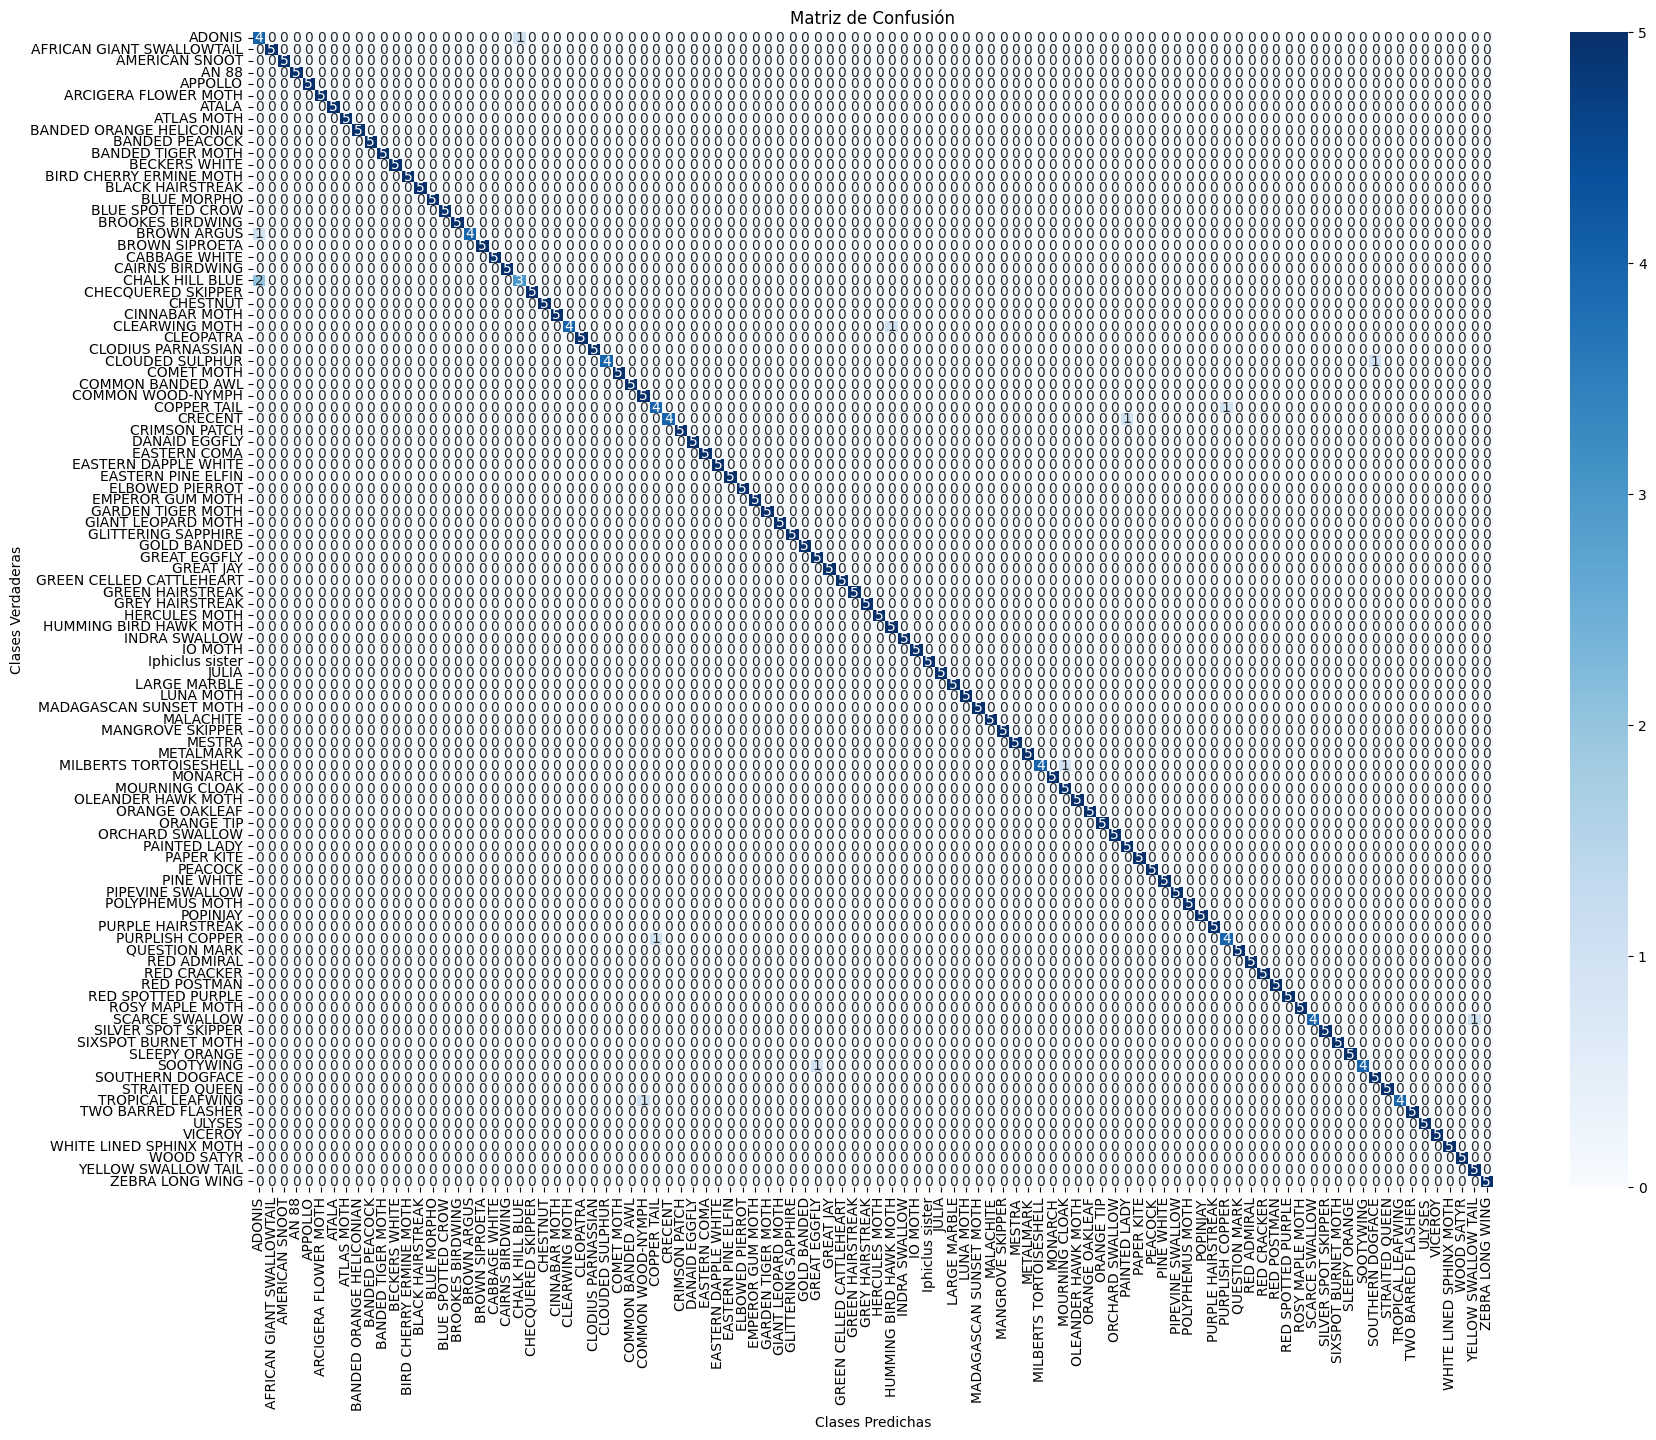

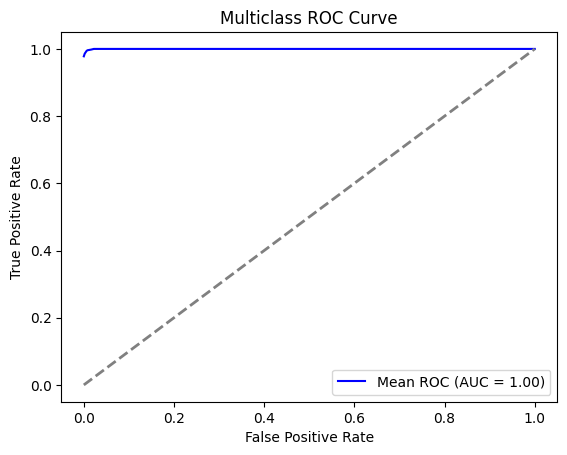

                           precision    recall  f1-score   support

                   ADONIS       0.57      0.80      0.67         5
AFRICAN GIANT SWALLOWTAIL       1.00      1.00      1.00         5
           AMERICAN SNOOT       1.00      1.00      1.00         5
                    AN 88       1.00      1.00      1.00         5
                  APPOLLO       1.00      1.00      1.00         5
     ARCIGERA FLOWER MOTH       1.00      1.00      1.00         5
                    ATALA       1.00      1.00      1.00         5
               ATLAS MOTH       1.00      1.00      1.00         5
 BANDED ORANGE HELICONIAN       1.00      1.00      1.00         5
           BANDED PEACOCK       1.00      1.00      1.00         5
        BANDED TIGER MOTH       1.00      1.00      1.00         5
            BECKERS WHITE       1.00      1.00      1.00         5
  BIRD CHERRY ERMINE MOTH       1.00      1.00      1.00         5
         BLACK HAIRSTREAK       1.00      1.00      1.00     

In [28]:
# Reseteo del generador antes de predecir el modelo
testing_dataset.reset()
# Predecir las clases para el conjunto de prueba
predictions = model_saved.predict(testing_dataset)

# Convertir las probabilidades predichas en etiquetas de clase
# np.argmax selecciona la clase con la probabilidad más alta en cada predicción
predicted_classes = np.argmax(predictions, axis=1)

# Imprimir las clases predichas para inspección
print("Clases predichas:", predicted_classes)

true_labels = testing_dataset.classes
# Se obtiene accuracy
accuracy = calculate_accuracy(true_labels, predicted_classes)

# Matriz de confusión
plot_confusion_matrix(true_labels, predicted_classes, class_names)

# Curva roc auc
plot_multiclass_roc_auc(true_labels, predictions, class_names)

# Calcula el reporte de clasificación y se imprime
report = classification_report(true_labels, predicted_classes, target_names=class_names)
print(report)

# EFFICIENTNET

In [29]:
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               # Nombre del modelo y archivo
model_eff_name="efficientnetB5"
name_file="efficientnetB50_v0_ADAM"
num_epochs=30

# Creación de modelo ResNet101 mostrando summary
model_eff = create_model_EfficientNet(model_name=model_eff_name, show_summary=True)

# Configuración del optimizador
optimizer= SGD()
#optimizer= Adam()
# Compilación el modelo con el optimizador, función de pérdida y métricas
model_eff.compile(optimizer, loss='categorical_crossentropy', metrics=METRICS)

# Callback para reducir la tasa de aprendizaje si no hay mejora en 'val_loss'
rlr_callback = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, mode='min', verbose=1)
# Callback para detener el entrenamiento si no hay mejora en 'val_loss'
early_callback = EarlyStopping(monitor='val_loss', patience=5, mode='min', verbose=1)

# Entrenamiento del modelo
history = model_eff.fit(training_dataset, epochs=num_epochs,
         steps_per_epoch=394,
         validation_data=validation_dataset,
         validation_steps=16,
         callbacks=[rlr_callback, early_callback],
                    class_weight=class_weights_dict)

# Almacena el modelo y su historial
save_result_model(model_eff, history, result_dir, name_file)

115263384/115263384 [==============================] - 6s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 224, 224, 3)          0         ['input_4[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 224, 224, 3)          7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 rescaling_1 (Rescaling) 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:2723: UserWarning: Metric F1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()


394/394 [==============================] - 197s 369ms/step - loss: 4.5094 - categorical_accuracy: 0.0884 - precision: 0.9799 - recall: 0.0372 - auc: 0.6405 - prc: 0.0688 - f1_score: 0.0717 - val_loss: 4.5454 - val_categorical_accuracy: 0.0400 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5982 - val_prc: 0.0187 - val_f1_score: 0.0000e+00 - lr: 0.0100
Epoch 2/30
394/394 [==============================] - 146s 369ms/step - loss: 3.8663 - categorical_accuracy: 0.3219 - precision: 0.8654 - recall: 0.0036 - auc: 0.8627 - prc: 0.2001 - f1_score: 0.0071 - val_loss: 3.1310 - val_categorical_accuracy: 0.5920 - val_precision: 1.0000 - val_recall: 0.0100 - val_auc: 0.9643 - val_prc: 0.4486 - val_f1_score: 0.0198 - lr: 0.0100
Epoch 3/30
394/394 [==============================] - 146s 370ms/step - loss: 2.0272 - categorical_accuracy: 0.6332 - precision: 0.9298 - recall: 0.1850 - auc: 0.9787 - prc: 0.6099 - f1_score: 0.3086 - val_loss: 1.6484 - val_categorical_accuracy: 0.7260 - v

# Métricas

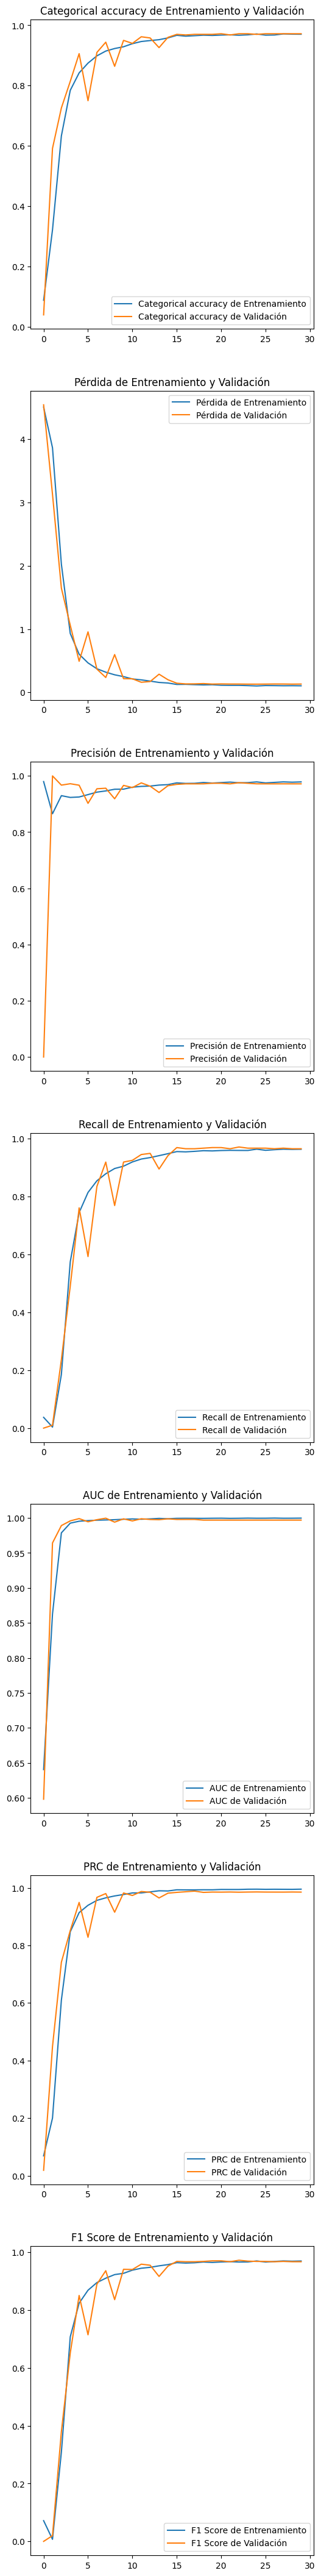

In [30]:
# se carga el modelo y la historia
#[model_eff_saved, history_eff_saved] = load_result_model(result_dir,name_file)
model_eff_saved=model_eff
history_eff_saved=history
plot_training_history(history_eff_saved)

# Evaluación

In [31]:
# Reseteo del generador antes de evaluar el modelo
testing_dataset.reset()

# Evaluar el modelo en el conjunto de prueba
results_eff = model_eff_saved.evaluate(testing_dataset)

# Se obtienen los nombres de las métricas
metrics_names = model_eff_saved.metrics_names

# Imprimir todas las métricas
print("Métricas en el conjunto de prueba:")
for metric, value in zip(metrics_names, results_eff):
    print(f"{metric}: {value}")

 1/16 [>.............................] - ETA: 2s - loss: 0.0947 - categorical_accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 1.0000 - prc: 0.9971 - f1_score: 0.9687

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:2723: UserWarning: Metric F1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()


16/16 [==============================] - 1s 77ms/step - loss: 0.0916 - categorical_accuracy: 0.9700 - precision: 0.9777 - recall: 0.9660 - auc: 1.0000 - prc: 0.9960 - f1_score: 0.9718
Métricas en el conjunto de prueba:
loss: 0.0916166678071022
categorical_accuracy: 0.9700000286102295
precision: 0.97773277759552
recall: 0.9660000205039978
auc: 0.9999562501907349
prc: 0.9960487484931946
f1_score: 0.9718309640884399


# Predicción

16/16 [==============================] - 5s 70ms/step
Clases predichas: [ 0  0  0  0 21  1  1  1  1  1  2  2  2  2  2  3  3  3  3  3  4  4  4  4
  4  5  5  5  5  5  6  6  6  6  6  7  7  7  7  7  8  8  8  8  8  9  9  9
  9  9 10 41 10 10 10 37 11 11 11 11 12 12 12 12 12 13 13 13 13 13 14 14
 14 14 14 15 15 15 15 15 16 16 16 16 16  0 17 17 17 17 18 18 18 18 18 19
 19 19 19 19 20 20 20 20 20 21 21  0 21 21 22 22 22 22 22 23 23 23 23 23
 24 24 24 24 24 25 51 25 25 25 26 26 26 26 26 27 27 27 27 27 28 28 28 28
 28 29 29 29 29 29 30 30 30 30 30 31 31 31 31 31 32 32 32 33 32 70 33 33
 33 33 34 34 34 34 34 35 35 35 35 35 36 36 36 36 36 37 56 37 37 56 38 38
 38 38 38 39 39 39 39 39 40 40 40 40 40 41 41 41 41 41 42 42 42 42 42 43
 43 43 43 43 44 44 44 44 44 45 45 45 45 35 46 46 46 46 46 47 47 47 47 47
 48 48 48 48 48 49 49 49 49 49 50 50 50 50 50 51 51 51 51 51 52 52 52 52
 52 53 53 53 53 53 54 54 54 54 54 55 55 55 55 55 56 56 56 56 68 57 57 57
 57 57 58 58 58 58 58 59 59 59 59 59 60 60 60 60 60 

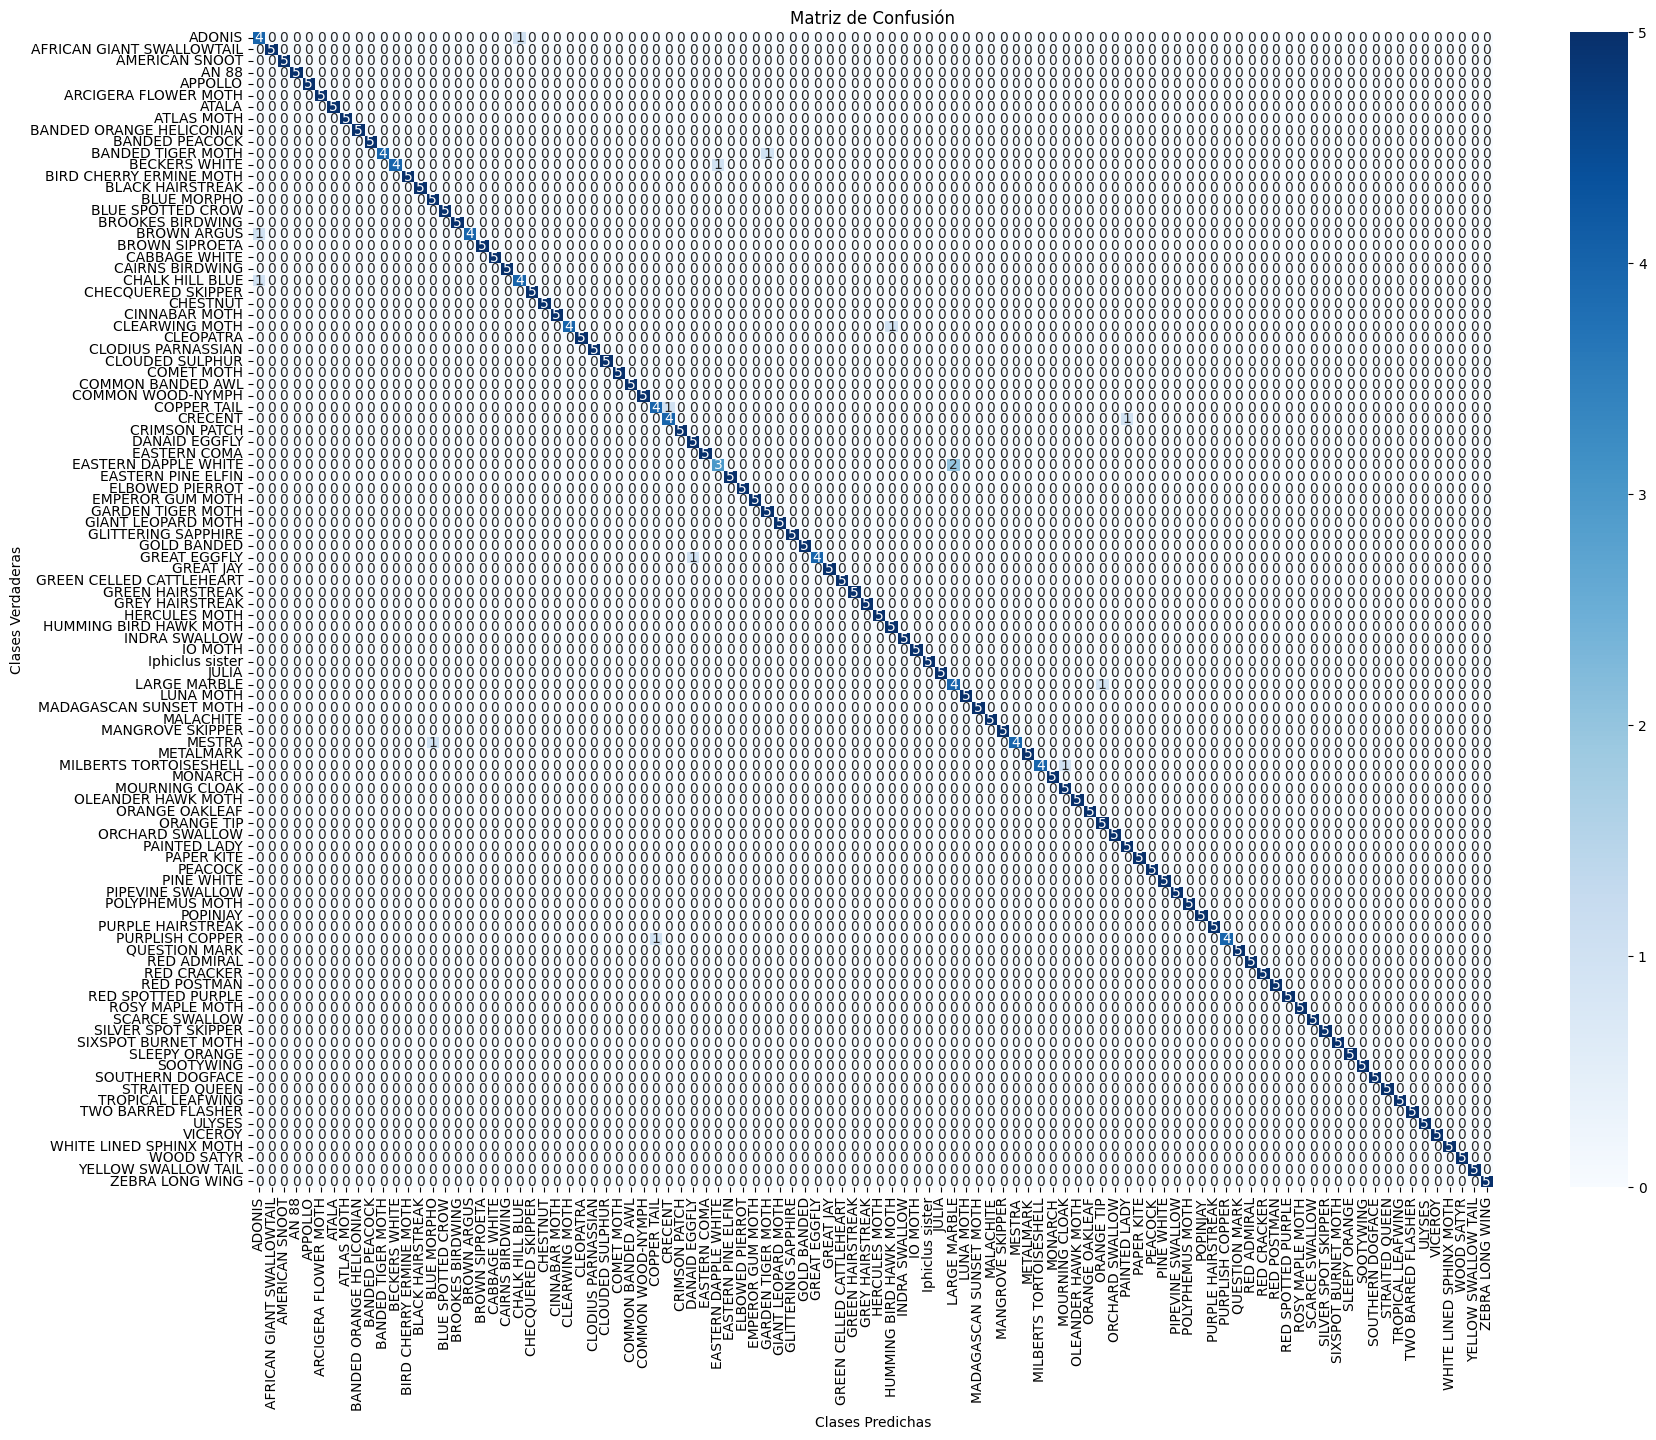

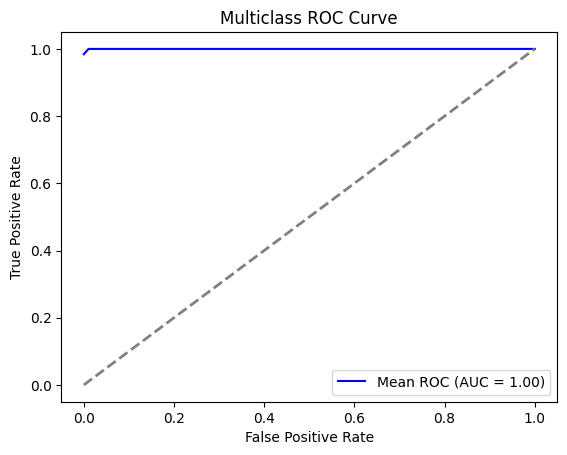

                           precision    recall  f1-score   support

                   ADONIS       0.67      0.80      0.73         5
AFRICAN GIANT SWALLOWTAIL       1.00      1.00      1.00         5
           AMERICAN SNOOT       1.00      1.00      1.00         5
                    AN 88       1.00      1.00      1.00         5
                  APPOLLO       1.00      1.00      1.00         5
     ARCIGERA FLOWER MOTH       1.00      1.00      1.00         5
                    ATALA       1.00      1.00      1.00         5
               ATLAS MOTH       1.00      1.00      1.00         5
 BANDED ORANGE HELICONIAN       1.00      1.00      1.00         5
           BANDED PEACOCK       1.00      1.00      1.00         5
        BANDED TIGER MOTH       1.00      0.80      0.89         5
            BECKERS WHITE       1.00      0.80      0.89         5
  BIRD CHERRY ERMINE MOTH       1.00      1.00      1.00         5
         BLACK HAIRSTREAK       1.00      1.00      1.00     

In [32]:
# Reseteo del generador antes de predecir el modelo
testing_dataset.reset()

# Predicción de las clases para el conjunto de prueba
predictions_eff = model_eff_saved.predict(testing_dataset)

# Se convierten las probabilidades predichas en etiquetas de clase
predicted_classes_eff = np.argmax(predictions_eff, axis=1)
print("Clases predichas:", predicted_classes_eff)

true_labels = testing_dataset.classes
# Se obtiene accuracy
accuracy = calculate_accuracy(true_labels, predicted_classes_eff)

# Matriz de confusión
plot_confusion_matrix(true_labels, predicted_classes_eff, class_names)

# Curva roc auc
plot_multiclass_roc_auc(true_labels, predictions_eff, class_names)

# Calcula el reporte de clasificación y se imprime
report = classification_report(true_labels, predicted_classes_eff, target_names=class_names)
print(report)
